# Challenge Set 1:  MTA Turnstile Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Scrape data from the MTA site and read into a DataFrame.
## Pull data from all weeks in May 2017.
### Begin work on the turnstiles_df DataFrame, which is the basis for all other DF's in the project.

def get_data(week_nums):
    # base url
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        # concat our week onto url.. 
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [170506, 170513, 170520, 170527]
turnstiles_df = get_data(week_nums)

In [3]:
# Set column names to lowercase.

turnstiles_df.columns = [column.lower().strip() for column in turnstiles_df.columns]

In [4]:
# Create datetime column.

turnstiles_df["datetime"] = pd.to_datetime(
                                    turnstiles_df.date +
                                    " " + turnstiles_df.time,
                                    format="%m/%d/%Y %H:%M:%S")

In [5]:
# Get rid of duplicated turnstile entries.
## Drop all but the first entry from a given turnstile at a given datetime.

turnstiles_df.sort_values(
                        ["c/a", "unit", "scp", "station", "datetime"],
                        inplace=True,
                        ascending=False)
turnstiles_df.drop_duplicates(
                            subset=["c/a", "unit", "scp", "station", "datetime"],
                            inplace=True)

In [6]:
# Drop the 'desc' feature as it is not relevant to my analysis.

turnstiles_df = turnstiles_df.drop(
                            ["desc"],
                            axis=1,
                            errors="ignore")

In [10]:
# Daily Analysis.on turnstile entries.
## Create turnstiles_daily DataFrame to analyze turnstile activity at daily level.
### Develop new DataFrame by bringing in the first turnstile recording on each day.

turnstiles_daily = turnstiles_df.groupby(
                        ["c/a", "unit", "scp", "station", 'date']
                        ).entries.first().reset_index()

In [11]:
# Turnstile records are an incrementing counter;
## Need to subtract each day's recording from the previous day's to get daily activity.
### First, create two new features: the datetime of the previous day, and the turnstile count from the previous day.

turnstiles_daily[["prev_date", "prev_entries"]] = (turnstiles_daily
                                                       .groupby(["c/a", "unit", "scp", "station"])
                                                       ["date", "entries"]
                                                       .transform(lambda grp: grp.shift(1)))

In [12]:
# Drop the resulting rows with null values.
## These were the first records in each group, which had no corresponding previous day.

turnstiles_daily.dropna(
                    subset=["prev_date"],
                    axis=0,
                    inplace=True)

In [66]:
# Define a function to return the difference between the current day's turnstile count and the previous day's.

def get_entry_diffs(row, max_counter):
    counter = row["entries"] - row["prev_entries"]
    # Sometimes the counter number drops; I am assuming that the counter has reset to zero.
    if counter < 0:
        counter = 0
    # Remove entries that are clearly too big (exceed the max_counter value).
    if counter > max_counter:
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        counter = 0
    return counter

# Develop new column daily_entries, containing the difference.
## This value is the number of entries corresponding to each day,
### which will be used for the next part of the analysis and visualizations.

turnstiles_daily["daily_entries"] = turnstiles_daily.apply(get_entry_diffs, axis=1, max_counter=1000000)

In [14]:
# Group the entries by Control Area to understand traffic at different station entrances.

control_areas = turnstiles_daily.groupby(['station', 'c/a']).daily_entries.sum().reset_index()

In [67]:
# Create a DataFrame containing the top 30 stations by entries,
## to be used later for visualization.

top = (control_areas.sort_values('daily_entries', ascending=False).head(30))

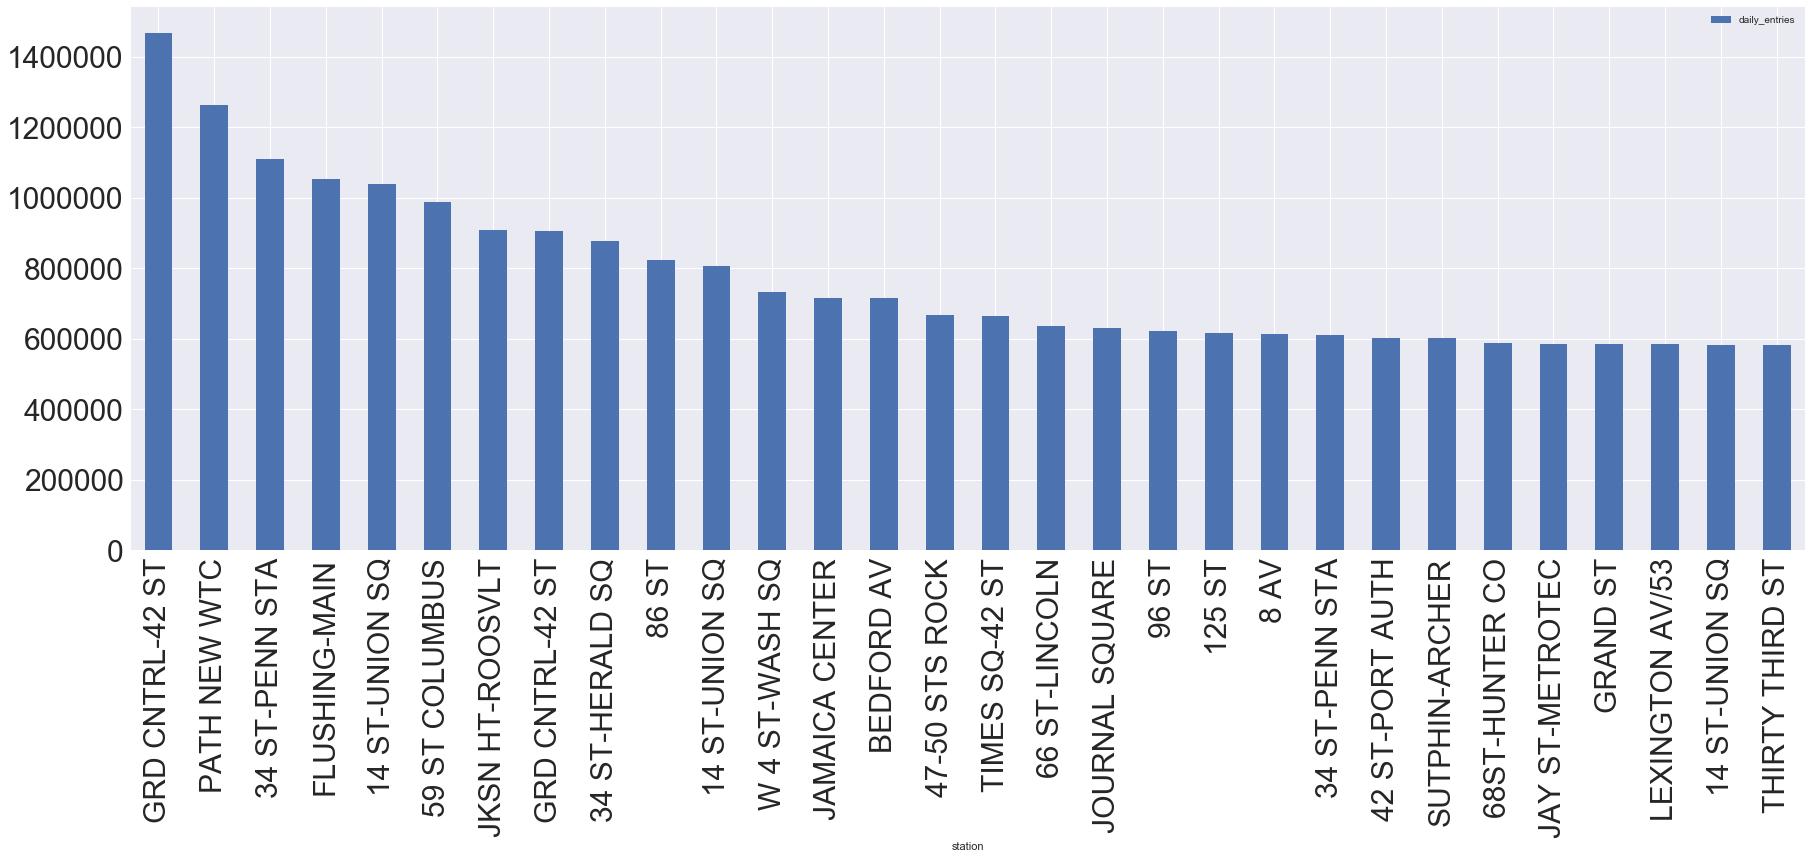

In [68]:
# Plot of the top 30 station entrances (Control Areas) by daily entries.

top.plot('station', kind='bar', figsize=(30, 10), fontsize=30);

In [22]:
# Hourly analysis of entries.
## Develop a new DataFrame, turnstiles_hourly, in an analagous manner to above.
### Seek to understand the flow of entries and exits during different times of day.
#### Begin developing new DataFrame by grouping and copying the original DataFrame.

turnstiles_hourly = turnstiles_df.groupby(
                                    ["c/a", "unit", "scp", "station", 'datetime']
                                    ).entries.first(
                                    ).reset_index()

In [23]:
# Develop previous datetime and previous entry rows.

turnstiles_hourly[["prev_datetime", "prev_entries"]] = (turnstiles_hourly
                                                       .groupby(["c/a", "unit", "scp", "station"])
                                                        ["datetime", "entries"]
                                                       .transform(lambda grp: grp.shift(1)))

In [24]:
# Drop the rows with null values resulting from the shift.

turnstiles_hourly.dropna(subset=["prev_datetime"], axis=0, inplace=True)

In [69]:
# Compute differences between current counter reading and previous hour's.
## Develop new column using the above get_entry_diffs function.

turnstiles_hourly["hourly_entries"] = turnstiles_hourly.apply(get_entry_diffs, axis=1, max_counter=10000)

In [27]:
# Develop time feature, which is the hour component of the datetime feature.
## This will enable comparison at time-of-day.

turnstiles_hourly['time'] = pd.DatetimeIndex(turnstiles_hourly['datetime']).hour

In [97]:
# Develop new DataFrame, mean_hourly_entries,
## to record the mean number of entries at a specific time of day for each station.
### The new DataFrame's hourly_entries feature will be the basis for this part of the analysis.

mean_hourly_entries = turnstiles_hourly.groupby(['station', 'time']).hourly_entries.mean().reset_index()

In [103]:
# See how many hours have an entry at each station.
## Path stations in particular seem to have good hourly data coverage,
### as well as some of the bigger Manhattan MTA stops.
#### However, many of the stops only report their turnstiles on a 4-hour basis or similar.

mean_hourly_entries.station.value_counts()

EXCHANGE PLACE     24
NEWARK HM HE       24
GROVE STREET       24
NEWARK BM BW       24
THIRTY THIRD ST    24
14TH STREET        24
9TH STREET         24
THIRTY ST          24
LACKAWANNA         24
CHRISTOPHER ST     24
JOURNAL SQUARE     24
PATH NEW WTC       24
NEWARK HW BMEBE    24
PAVONIA/NEWPORT    24
CITY / BUS         24
NEWARK C           24
TWENTY THIRD ST    24
PATH WTC 2         24
HARRISON           24
FULTON ST          19
86 ST              15
125 ST             15
CANAL ST           15
34 ST-PENN STA     15
79 ST              15
HALSEY ST          15
135 ST             14
VAN SICLEN AV      14
WALL ST            14
PROSPECT AV        14
                   ..
BEACH 90 ST         6
85 ST-FOREST PK     6
JACKSON AV          6
BRONX PARK EAST     6
VERNON-JACKSON      6
UTICA AV            6
MOSHOLU PKWY        6
ZEREGA AV           6
KOSCIUSZKO ST       6
ROCKAWAY PARK B     6
57 ST               6
BOTANIC GARDEN      6
AVENUE J            6
AQUEDUCT RACETR     6
SHEPHERD A

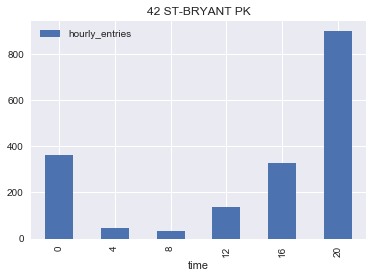

In [82]:
# Try plotting the entries over a day for given station. E.g. 42 ST-BRYANT PK
## Plotting several of these, I got the idea to visualize many stations' foot traffic
### over the course of an average day.
#### I'd like to plot a heatmap of station activity vs time of day for many stations,
##### to get a view of how stations compare to each other in terms of busy times.

sta = '42 ST-BRYANT PK'
x = mean_hourly_entries[mean_hourly_entries.station == sta]
x.plot('time', 'hourly_entries', kind='bar', title=sta);

In [84]:
top_x = 7

# Get list of top stations, which will be used as a filter for the pivot.
top_entries = top.drop('c/a', axis=1).head(top_x)

# Create a chart (a pivoted DataFrame) to feed into the seaborn heatmap.
mean_hourly_entries.columns = mean_hourly_entries.columns.str.title()
entries_chart = mean_hourly_entries.pivot(index='Station', columns='Time')['Hourly_Entries']
mask = np.in1d(entries_chart.index, top_exits.station)
entries_chart = entries_chart[mask].drop([0, 1, 2, 3, 4, 5, 6, 15, 19, 23], axis=1)
station_names = ['14th St Union Square', '34th St Penn Station', '59th St Columbus Circle',
                'Flushing Main Street', 'Grand Central 42nd St', 'Jackson Heights Roosevelt Avenue',
                'Path New WTC']
entries_chart.index = station_names

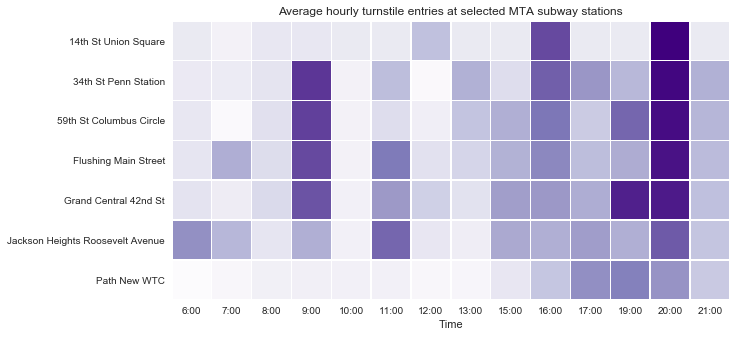

In [91]:
# Plot the heatmap with seaborn.

plt.figure(figsize=(10, 10))
plt.xlabel('Time of Day')
plt.ylabel('Station')
plt.title('Average hourly turnstile entries at selected MTA subway stations')
sns.heatmap(entries_chart.interpolate(method='linear',
                                   limit_direction='both'),
                                    square=True,
                                    cmap='Purples',
                                    linewidths=.5,
                                    cbar=False,
                                    xticklabels=["{0!s}:00".format((hour - 1)) for hour in entries_chart.columns]);

In [35]:
# Hourly analysis of turnstile exits.
## Aim to perform a similar analysis as before,
### but focus on station exits rather than entries.
#### Develop a new DataFrame, exits_hourly, based on the original DataFrame.
##### Development will be similar to the hourly entries analysis in teh preceding section.

exits_hourly = turnstiles_df.groupby(["c/a", "unit", "scp", "station", 'datetime']).exits.first().reset_index()

In [36]:
# Create columns for previous day's datetime and exits.

exits_hourly[['prev_datetime', 'prev_exits']] = exits_hourly.groupby(
                                                                ['c/a', 'unit', 'scp', 'station'])['datetime', 'exits']\
                                                                .transform(lambda grp: grp.shift(1))

In [37]:
# Drop the rows with resulting null values.

exits_hourly.dropna(subset=['prev_datetime'], axis=0, inplace=True)

In [38]:
# Define function to compute difference between current an previous exit counter levels.
## (The exits counts take the same form at those for entries: the MTA reports
### An aggregrate counter, and difference must be taken between hours to
#### arrive at actual hourly flow.)

def get_exit_diffs(row, max_counter):
    counter = row['exits'] - row['prev_exits']
    if counter < 0:
        counter = 0
    if counter > max_counter:
        counter = min(row['exits'], row['prev_exits'])
    if counter > max_counter:
        counter = 0
    return counter

# Create new column using above function.

exits_hourly['hourly_exits'] = exits_hourly.apply(get_exit_diffs, axis=1, max_counter=10000)

In [39]:
# Extract the hour component of each observation's datetime.

exits_hourly['time'] = pd.DatetimeIndex(exits_hourly['datetime']).hour

In [40]:
# Calculate mean for each hour-of-day group.
## Store the results in a new DataFrame, mean_hourly_exits.
### The result of this calculation will be the basis for analysis of this section.

mean_hourly_exits = exits_hourly.groupby(['station', 'time'], as_index=False).hourly_exits.mean()

In [64]:
# Get list of top stations, to use as filter for the pivot.
top_x = 7
top_exits = top.drop('c/a', axis=1).head(top_x)

# Create a chart (a pivoted DataFrame) to feed into the seaborn heatmap.
mean_hourly_exits.columns = mean_hourly_exits.columns.str.title()
exits_chart = mean_hourly_exits.pivot(index='Station', columns='Time')['Hourly_Exits']
mask = np.in1d(exits_chart.index, top_exits.station)
exits_chart = exits_chart[mask].drop([0, 1, 2, 3, 4, 5, 6, 15, 19, 23], axis=1)

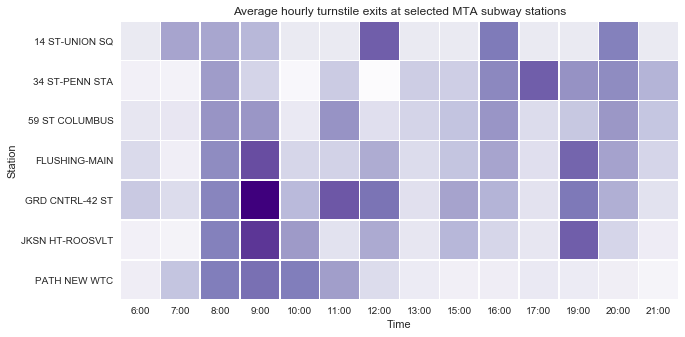

In [93]:
# Plot the heatmap with seaborn.

plt.figure(figsize=(10, 10))
plt.xlabel('Time of Day')
plt.ylabel('Station')
plt.title('Average hourly turnstile exits at selected MTA subway stations')
sns.heatmap(exits_chart.interpolate(method='linear',
                                   limit_direction='both'),
                                    square=True,
                                    cmap='Purples',
                                    linewidths=.5,
                                    cbar=False,
                                    xticklabels=["{0!s}:00".format((hour - 1)) for hour in exits_chart.columns]);